# Timeseries Analysis: Solar Panel Data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fbprophet as fb
import statsmodels as sm


from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.ar_model import AR
from fbprophet import Prophet


# Questions:
# How are the panels degrading over time?
# How many years till the panels have lost 50% of their power generating capability (on average)?
# Projections of power output for next year (sum)

In [2]:
KWH = pd.read_csv('KWH.csv', parse_dates={'ds':[0]}) # Makes a date variable from 0th column
KWH.head()

,ds,kwh
0,2017-01-01,23.05
1,2017-01-02,21.86
2,2017-01-03,23.10
3,2017-01-04,18.28
4,2017-01-05,12.30


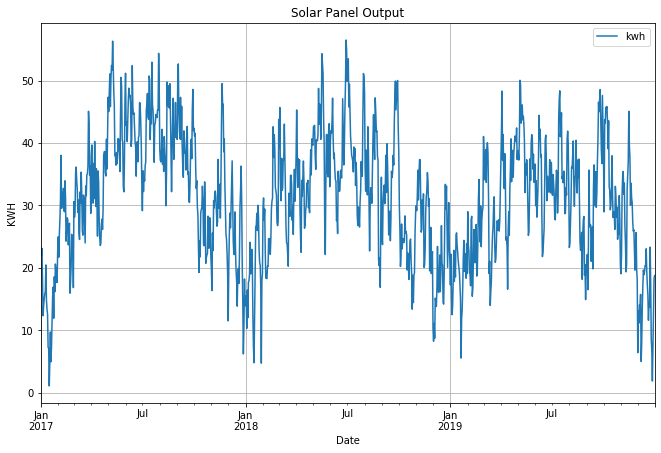

In [3]:
#plt.figure()
KWH_ind = KWH.set_index('ds') # Uses index as date
KWH_ind.plot(figsize=(11,7)) 
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('KWH')
plt.title('Solar Panel Output')
plt.show()
# Clear yearly seasonality. Overall trend of solar panel decay. 

# Idea: plot of 3 years on top of each other

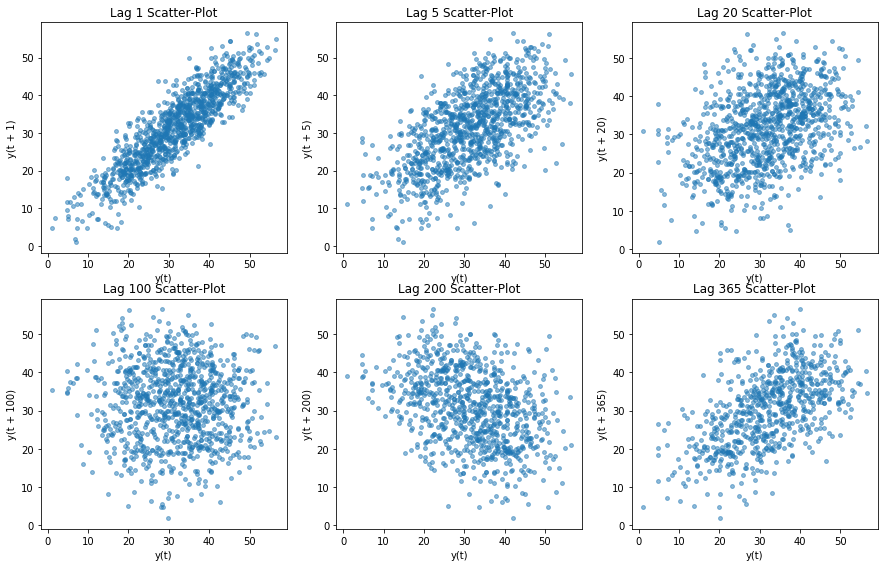

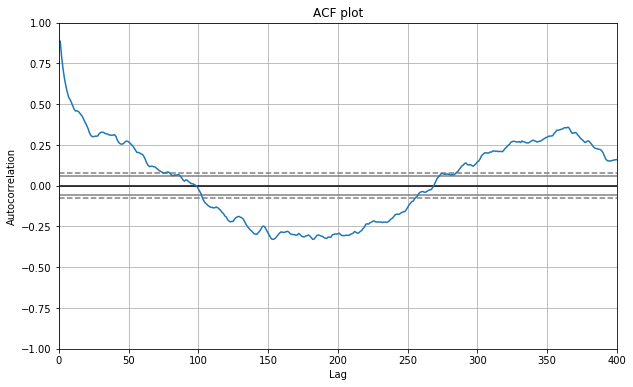

In [4]:
 # Definite correlation between points. Some serial correlation going on here! 
# Problem: SEs will appear much lower than they actually are!
plt.figure(figsize=(15,8))
plt.subplots_adjust(bottom=.001)

for i,v  in enumerate([1,5,20,100,200,365]):
    plt.subplot(2,3,i+1)
    pd.plotting.lag_plot(KWH_ind, lag=v,s=15, alpha=.5)
    plt.title('Lag {} Scatter-Plot'.format(v))

plt.show()

plt.figure(figsize=(10,6))
pd.plotting.autocorrelation_plot(KWH_ind) # ACF plot (Points are positively correlated after a year).
plt.xlim(0,400)
plt.title('ACF plot')
plt.show()

In [5]:
# How To Capture Seasonality
# Future Q: Where to put the knots?
from patsy import dmatrix
KWH['day'] = KWH['ds'].dt.dayofyear
KWH['prop'] = KWH['day'] / (365 + (KWH['ds'].dt.year % 4 == 0)*1)

X = dmatrix("-1 + bs(train, degree =3, knots=(.1, .3, .7, .9))", {"train": KWH['prop']}, return_type='dataframe')
X.columns = ['bs' + str(x) for x in range(1,X.shape[1]+1)]
X

,bs1,bs2,bs3,bs4,bs5,bs6,bs7
0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,0.081380,0.000768,0.000001,0.000000e+00,0.000000,0.000000,0.000000
2,0.156633,0.003030,0.000008,0.000000e+00,0.000000,0.000000,0.000000
3,0.225953,0.006720,0.000028,0.000000e+00,0.000000,0.000000,0.000000
4,0.289530,0.011775,0.000065,0.000000e+00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
1090,0.000000,0.000000,0.000000,6.267323e-05,0.011362,0.282629,0.705946
1091,0.000000,0.000000,0.000000,2.644027e-05,0.006482,0.220355,0.773136
1092,0.000000,0.000000,0.000000,7.834154e-06,0.002921,0.152611,0.844459
1093,0.000000,0.000000,0.000000,9.792692e-07,0.000740,0.079219,0.920039


In [34]:
# Timeseries model (AR1)
# Questions: Don't you need to center the data first?

# Assumptions:
# Weakly stationary series (Covariance stationary):
# Covariance - stationary: Same mean, covariance is dependent on relative position, not absolute position (on i not n)
# Stationary (same mean)
# Constant Variance and correlation is a function of relative positions.
# Errors are correlation free after 


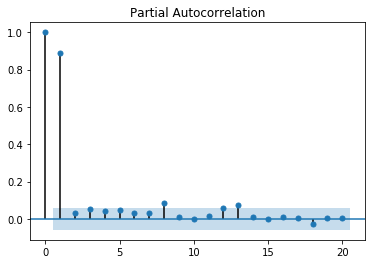

In [27]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
# The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. Removes indirect correlations. 
# Suggests AR1 is sufficient. Maybe AR8, but it may just be noise.
sm.graphics.tsaplots.plot_pacf(KWH['kwh'], lags=20)
plt.show()

arP_sel = ar_select_order(endog=KWH['kwh'], maxlag=10)
arP_sel.aic
arP_sel._bic # Select best lag based on AIC/BIC

ar1_mdl = AutoReg(endog=KWH['kwh'], lags=1,trend='ct', exog=X).fit()

In [28]:
ar1_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    kwh   No. Observations:                 1095
Model:                   AutoReg-X(1)   Log Likelihood               -3205.453
Method:               Conditional MLE   S.D. of innovations              4.532
Date:                Tue, 28 Jul 2020   AIC                              3.042
Time:                        22:24:30   BIC                              3.093
Sample:                             1   HQIC                             3.061
                                 1095                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.5762      1.350      2.649      0.008       0.931       6.222
trend         -0.0012      0.000     -2.518      0.012      -0.002      -0.000
kwh.L1         0.7736      0.019     40.379      0.000       0.736       0.811
bs1            0.8394      1.945      0.432      0.666      -2.973       4.652
bs2            3.2093      1.361      2.359      0.018       0.543       5.876
bs3            6.7685      1.747      3.874      0.000       3.344      10.193
bs4            5.3931      1.547      3.486      0.000       2.361       8.425
bs5            3.7719      1.587      2.376      0.017       0.661       6.883
bs6            1.1747      1.600      0.734      0.463      -1.962       4.312
bs7            1.5603      1.790      0.872      0.383      -1.949       5.069
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2927           +0.0000j            1.2927            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
X.head

<bound method NDFrame.head of            bs1       bs2       bs3           bs4       bs5       bs6       bs7
0     0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000  0.000000
1     0.081380  0.000768  0.000001  0.000000e+00  0.000000  0.000000  0.000000
2     0.156633  0.003030  0.000008  0.000000e+00  0.000000  0.000000  0.000000
3     0.225953  0.006720  0.000028  0.000000e+00  0.000000  0.000000  0.000000
4     0.289530  0.011775  0.000065  0.000000e+00  0.000000  0.000000  0.000000
...        ...       ...       ...           ...       ...       ...       ...
1090  0.000000  0.000000  0.000000  6.267323e-05  0.011362  0.282629  0.705946
1091  0.000000  0.000000  0.000000  2.644027e-05  0.006482  0.220355  0.773136
1092  0.000000  0.000000  0.000000  7.834154e-06  0.002921  0.152611  0.844459
1093  0.000000  0.000000  0.000000  9.792692e-07  0.000740  0.079219  0.920039
1094  0.000000  0.000000  0.000000  0.000000e+00  0.000000  0.000000  1.000000

[1095 rows x 7 column

In [24]:
ar1_mdl.predict()
ar1_mdl.fittedvalues

1       21.475893
2       20.624607
3       21.652833
4       17.992789
5       13.435062
          ...    
1090     8.956928
1091     5.193706
1092     9.651102
1093    14.802268
1094    17.970763
Length: 1094, dtype: float64

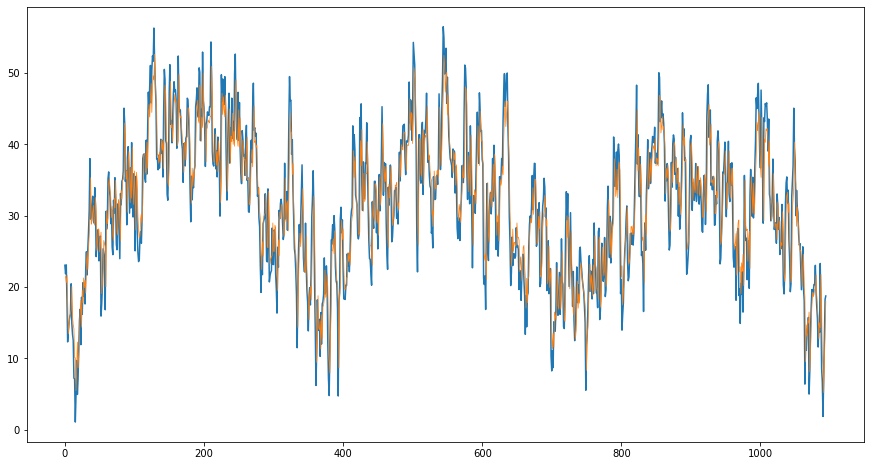

AttributeError: module 'matplotlib.pyplot' has no attribute 'score'

In [20]:
# Plot the model
plt.figure(figsize=(15,8))
plt.plot(KWH['kwh'])
plt.plot(ar1_mdl.fittedvalues, lw=.75)
plt.show()

plt.score()


## Prophet python package

In [207]:
KWH.columns = ['ds','y']
m = Prophet(weekly_seasonality=False, daily_seasonality=False, n_changepoints=0, yearly_seasonality=6,  
            interval_width=.95,seasonality_mode='multiplicative',uncertainty_samples=1000).fit(KWH)
nxtyr = m.make_future_dataframe(periods=365)


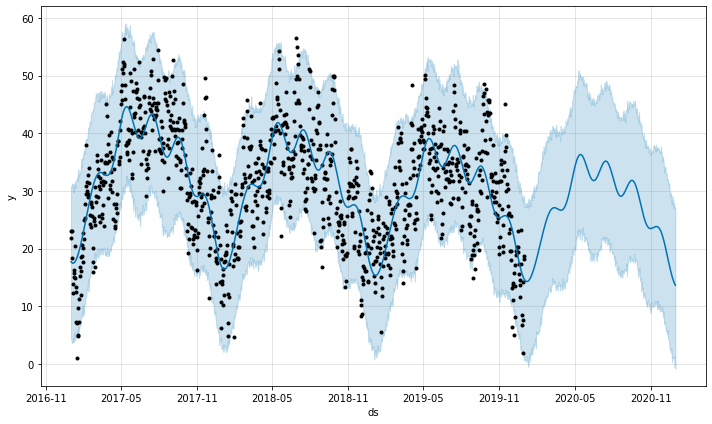

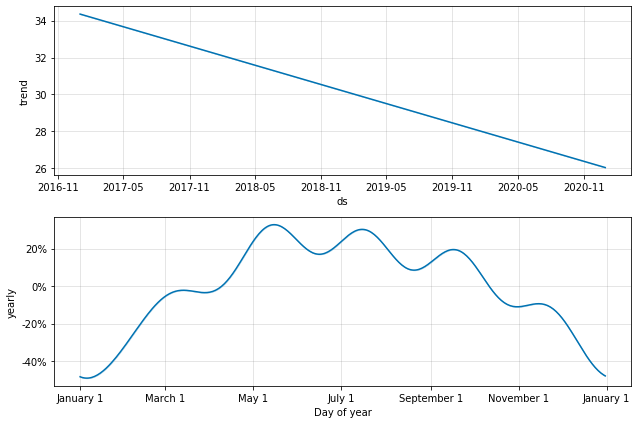

In [208]:
pred = m.predict(nxtyr)
m.plot(pred)
plt.show()
m.plot_components(pred)
plt.show()

In [210]:
dir(m)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'changepoint_prior_scale',
 'changepoint_range',
 'changepoints',
 'changepoints_t',
 'component_modes',
 'construct_holiday_dataframe',
 'country_holidays',
 'daily_seasonality',
 'extra_regressors',
 'fit',
 'fit_kwargs',
 'fourier_series',
 'growth',
 'history',
 'history_dates',
 'holidays',
 'holidays_prior_scale',
 'initialize_scales',
 'interval_width',
 'linear_growth_init',
 'logistic_floor',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'm

In [222]:
print(m.params)
m.train_component_cols
#help(Prophet.sample_predictive_trend)

pd.Series(m.params['trend'][0]).diff()


OrderedDict([('k', array([[-0.1104467]])), ('m', array([[0.60799181]])), ('delta', array([[0.]])), ('sigma_obs', array([[0.12182688]])), ('beta', array([[-0.0056298 , -0.30205633, -0.03590738, -0.07723499,  0.00346174,
        -0.03176074, -0.01758804, -0.03914026, -0.06077751, -0.03159115,
         0.04072911, -0.00142573]])), ('trend', array([[0.60799181, 0.60789085, 0.60778989, ..., 0.49774702, 0.49764606,
        0.4975451 ]])), ('Y', array([[0.31370296, 0.3119105 , 0.31054272, ..., 0.26525323, 0.26247803,
        0.26004603]])), ('beta_m', array([[-0.0056298 , -0.30205633, -0.03590738, -0.07723499,  0.00346174,
        -0.03176074, -0.01758804, -0.03914026, -0.06077751, -0.03159115,
         0.04072911, -0.00142573]])), ('beta_a', array([[-0., -0., -0., -0.,  0., -0., -0., -0., -0., -0.,  0., -0.]]))])


0            NaN
1      -0.000101
2      -0.000101
3      -0.000101
4      -0.000101
          ...   
1090   -0.000101
1091   -0.000101
1092   -0.000101
1093   -0.000101
1094   -0.000101
Length: 1095, dtype: float64